In [1]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
pd.options.display.max_rows = 30
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
#Importamos la base de datos
properati = pd.read_csv("properati.csv")

In [3]:
#Como todas las filas en "operation" son ventas, 
#la columna no añade informacion, por lo que se remueve
properati = properati.drop(columns="operation")

In [10]:
#Por ahora nos deshacemos de las columnas "country_name","geonames_id","lat-lon","lat","lon","place_with_parent_names","place_name","properati_url","image_thumbnail"
properati = properati.drop(columns=["country_name","geonames_id","lat-lon","lat","lon","place_with_parent_names","place_name","properati_url","image_thumbnail"])

In [5]:
#Se le colocan estandares a las variables para lidiar con datos extremos
properati = properati[properati.price_usd_per_m2 < 8000]

properati = properati[properati.price_usd_per_m2 > 500]

properati = properati[properati.surface_covered_in_m2 < 600]

properati = properati[properati.surface_covered_in_m2 > 30]

properati = properati[properati.surface_total_in_m2 > 30]

properati = properati[properati.surface_total_in_m2 < 1000]

properati.shape

(53056, 25)

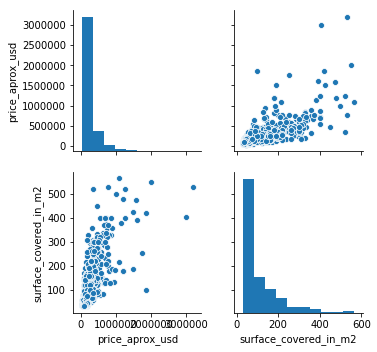

In [6]:
sns.pairplot(properati[["price_aprox_usd","surface_covered_in_m2"]].sample(800))


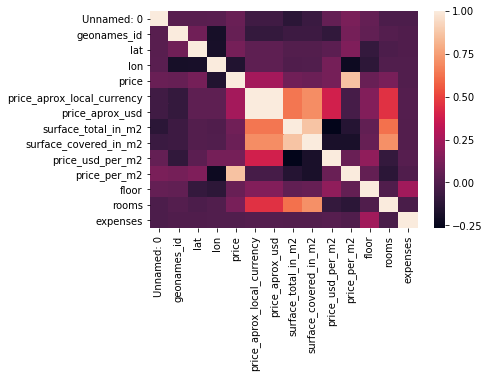

In [7]:
sns.heatmap(properati.corr())

In [8]:
#Dummies de las columnas listas
properati = pd.get_dummies(properati,["prop_type","curr"],columns=["property_type","currency"])


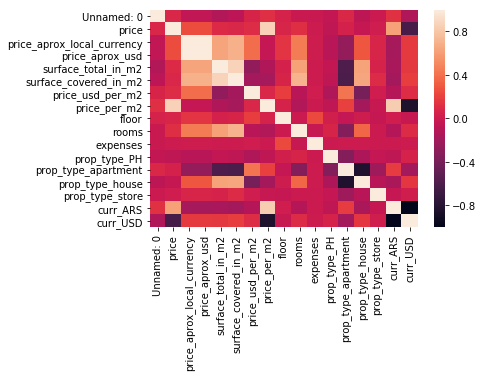

In [11]:
sns.heatmap(properati.corr())

In [113]:
prop_test = properati[["title"]]
#prop_test
#str.find()


def cuenta_ambientes(string):
    #programa para contar la cantidad de ambientes en title o descripcion
    
    existe_amb = string.find(" amb ")
    
    if existe_amb == -1:
        existe_amb = string.find(" amb. ")
    
    if existe_amb == -1:
        existe_amb = string.find(" AMB ")
    
    if existe_amb == -1:
        existe_amb = string.find(" AMB. ")

    if existe_amb == -1:
        existe_amb = string.find(" AMBIENTES")
    
    if existe_amb == -1:
        existe_amb = string.find(" ambientes")
    
    if existe_amb == -1:
        existe_amb = string.find(" ambiente ")
        
#    if existe_amb == -1:
#        existe_amb = string.find(" ambientes ")    
        
    if existe_amb == -1:
        if string.find(" monoambiente") != -1:
            return 1
    if existe_amb == -1:
        if string.find(" MONOAMBIENTE") != -1:
            return 1
        
    try: 
        int(string[existe_amb - 1])
    except:
        existe_amb = -1
        pass
        
    if existe_amb != -1:
        return string[existe_amb - 1]
    else:
        return np.nan

    
c = prop_test.applymap(cuenta_ambientes)
c.dropna().shape
#d = prop_test.sample(10).applymap(cuenta_ambientes)
#d.dropna().shape

(10050, 1)

In [105]:
prop_test

,title
0,2 AMB TIPO CASA SIN EXPENSAS EN PB
2,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
4,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...
6,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,..."
7,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...
8,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,..."
12,EXCELENTE DEPARTAMENTO 2 AMBIENTES CONTRAFRENT...
14,Vitraux Palermo
16,VENTA-MATADEROS-DUPLEX 4 AMB.
17,3 ambientes en venta en Acqua Golf 1 en Nordel...


In [144]:
properati

,Unnamed: 0,state_name,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title,prop_type_PH,prop_type_apartment,prop_type_house,prop_type_store,curr_ARS,curr_USD
684,684,Bs.As. G.B.A. Zona Oeste,120000.0,2117340.0,120000.0,88.0,82.0,1363.636364,1463.414634,11.0,4.0,1560.0,Venta de Departamento en edificio 4 AMBIENTES ...,DEPARTAMENTO EN VENTA,0,1,0,0,0,1
687,687,Bs.As. G.B.A. Zona Oeste,90000.0,1588005.0,90000.0,65.0,62.0,1384.615385,1451.612903,1.0,3.0,1070.0,Venta de Departamento en edificio 3 AMBIENTES...,DEPARTAMENTO EN VENTA,0,1,0,0,0,1
691,691,Capital Federal,152000.0,2681964.0,152000.0,52.0,52.0,2923.076923,2923.076923,6.0,2.0,1800.0,"Venta de Departamento 1 DORM en BELGRANO, Capi...",PH EN VENTA,1,0,0,0,0,1
692,692,Capital Federal,152000.0,2681964.0,152000.0,52.0,52.0,2923.076923,2923.076923,6.0,3.0,1800.0,"Venta de Departamento 1 DORM en BELGRANO, Capi...",PH EN VENTA,1,0,0,0,0,1
693,693,Capital Federal,152000.0,2681964.0,152000.0,52.0,52.0,2923.076923,2923.076923,6.0,3.0,1800.0,"Venta de Departamento 1 DORM en BELGRANO, Capi...",PH EN VENTA,1,0,0,0,0,1
694,694,Capital Federal,152000.0,2681964.0,152000.0,52.0,52.0,2923.076923,2923.076923,6.0,2.0,1800.0,"Venta de Departamento 1 DORM en BELGRANO, Capi...",PH EN VENTA,1,0,0,0,0,1
695,695,Capital Federal,152000.0,2681964.0,152000.0,52.0,52.0,2923.076923,2923.076923,6.0,3.0,1800.0,"Venta de Departamento 1 DORM en BELGRANO, Capi...",PH EN VENTA,1,0,0,0,0,1
746,746,Capital Federal,158000.0,2787831.0,158000.0,71.0,62.0,2225.352113,2548.387097,2.0,3.0,2653.0,Venta de Departamento 3 AMBIENTES en Caballito...,DEPARTAMENTO EN VENTA,0,1,0,0,0,1
750,750,Bs.As. G.B.A. Zona Norte,110000.0,1940895.0,110000.0,60.0,54.0,1833.333333,2037.037037,3.0,3.0,1163.0,Venta de Departamento 3 AMBIENTES en San Ferna...,DEPARTAMENTO EN VENTA,0,1,0,0,0,1
781,781,Capital Federal,138000.0,2434941.0,138000.0,66.0,56.0,2090.909091,2464.285714,7.0,2.0,2000.0,EXCELENTE DEPARTAMENTO SEMIPISO A ESTRENAR DE ...,DEPARTAMENTO EN VENTA,0,1,0,0,0,1


'JOSE HERNANDEZ   1400 DOS AMBIENTES ESTRENAR , CATEGORIA , VENTA'

,title
0,2 AMB TIPO CASA SIN EXPENSAS EN PB
2,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
4,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...
6,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,..."
7,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...
8,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,..."
12,EXCELENTE DEPARTAMENTO 2 AMBIENTES CONTRAFRENT...
14,Vitraux Palermo
16,VENTA-MATADEROS-DUPLEX 4 AMB.
17,3 ambientes en venta en Acqua Golf 1 en Nordel...
